In [17]:
import os

import pandas as pd
import numpy as np

import time

from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, PCA
from pyspark.ml.functions import vector_to_array
from pyspark.sql.functions import col
import pyspark.sql.functions as sf
import pyspark.sql.types as st
from pyspark.ml.recommendation import ALS
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, NaiveBayes, FMClassifier
from pyspark.ml import Pipeline, PipelineModel
from sim4rec.modules import Simulator

from replay.metrics import NDCG, Precision, RocAuc, Metric
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score
from replay.data_preparator import Indexer

from sim4rec.utils import pandas_to_spark, VectorElementExtractor
from sim4rec.modules import RealDataGenerator, SDVDataGenerator
from sim4rec.modules import evaluate_synthetic, EvaluateMetrics
from sim4rec.response import ParametricResponseFunction, BernoulliResponse

from replay.models import UCB, ItemKNN
from replay.models import RandomRec

%matplotlib inline
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

spark = SparkSession.builder\
    .appName('simulator_movielens')\
    .master('local[*]')\
    .config('spark.sql.shuffle.partitions', '192')\
    .config('spark.default.parallelism', '192')\
    .config('spark.driver.extraJavaOptions', '-XX:+UseG1GC')\
    .config('spark.executor.extraJavaOptions', '-XX:+UseG1GC')\
    .config('spark.sql.autoBroadcastJoinThreshold', '-1')\
    .config('spark.driver.memory', '256g')\
    .getOrCreate()
spark.sparkContext.setLogLevel('ERROR')

In [2]:
USER_PREFIX = 'user_'
ITEM_PREFIX = 'item_'

USER_SCHEMA = st.StructType(
    [st.StructField('user_idx', st.IntegerType())] +\
    [st.StructField(f'genre{i}', st.DoubleType()) for i in range(19)] +\
    [st.StructField('rating_avg', st.DoubleType())] +\
    [st.StructField(f'w2v_{i}', st.DoubleType()) for i in range(300)]
)
ITEM_SCHEMA = st.StructType(
    [st.StructField('item_idx', st.IntegerType())] +\
    [st.StructField('year', st.IntegerType())] +\
    [st.StructField('rating_avg', st.DoubleType())] +\
    [st.StructField(f'genre{i}', st.DoubleType()) for i in range(19)] +\
    [st.StructField(f'w2v_{i}', st.DoubleType()) for i in range(300)]
)
LOG_SCHEMA = st.StructType([
    st.StructField('user_idx', st.IntegerType()),
    st.StructField('item_idx', st.IntegerType()),
    st.StructField('relevance', st.DoubleType()),
    st.StructField('timestamp', st.IntegerType())
])

users_df_train = spark.read.csv('train/users.csv', header=True, schema=USER_SCHEMA)
items_df_train = spark.read.csv('train/items.csv', header=True, schema=ITEM_SCHEMA)
log_df_train   = spark.read.csv('train/rating.csv', header=True, schema=LOG_SCHEMA)

users_df_train = users_df_train.withColumnRenamed("user_idx", "user_id")
items_df_train = items_df_train.withColumnRenamed("item_idx", "item_id")
log_df_train = log_df_train.withColumnRenamed("user_idx", "user_id")
log_df_train = log_df_train.withColumnRenamed("item_idx", "item_id")

log_df_train = log_df_train.join(users_df_train, log_df_train['user_id'] == users_df_train['user_id'], 'leftsemi')
log_df_train = log_df_train.join(items_df_train, log_df_train['item_id'] == items_df_train['item_id'], 'leftsemi')

for c in users_df_train.columns[1:]:
    users_df_train = users_df_train.withColumnRenamed(c, 'user_' + c)
    
for c in items_df_train.columns[1:]:
    items_df_train = items_df_train.withColumnRenamed(c, 'item_' + c)

log_df_train = log_df_train.withColumn(
    'relevance', sf.when(sf.col('relevance') > 3, 1).otherwise(0))

users_df_train = users_df_train.cache()
items_df_train = items_df_train.cache()
log_df_train = log_df_train.cache()

print(users_df_train.count())
print(items_df_train.count())
print(log_df_train.count())

80650


27278


10000132


In [3]:
users_df_val = spark.read.csv('val/users.csv', header=True, schema=USER_SCHEMA)
items_df_val = spark.read.csv('val/items.csv', header=True, schema=ITEM_SCHEMA)
log_df_val   = spark.read.csv('val/rating.csv', header=True, schema=LOG_SCHEMA)

users_df_val = users_df_val.withColumnRenamed("user_idx", "user_id")
items_df_val = items_df_val.withColumnRenamed("item_idx", "item_id")
log_df_val = log_df_val.withColumnRenamed("user_idx", "user_id")
log_df_val = log_df_val.withColumnRenamed("item_idx", "item_id")

log_df_val = log_df_val.join(users_df_val, log_df_val['user_id'] == users_df_val['user_id'], 'leftsemi')
log_df_val = log_df_val.join(items_df_val, log_df_val['item_id'] == items_df_val['item_id'], 'leftsemi')

for c in users_df_val.columns[1:]:
    users_df_val = users_df_val.withColumnRenamed(c, 'user_' + c)

for c in items_df_val.columns[1:]:
    items_df_val = items_df_val.withColumnRenamed(c, 'item_' + c)

log_df_val = log_df_val.withColumn(
    'relevance', sf.when(sf.col('relevance') > 3, 1).otherwise(0))

users_df_val = users_df_val.cache()
items_df_val = items_df_val.cache()
log_df_val = log_df_val.cache()

print(users_df_val.count())
print(items_df_val.count())
print(log_df_val.count())

106573
27278


5000065


In [4]:
users_df_test = spark.read.csv('test/users.csv', header=True, schema=USER_SCHEMA)
items_df_test = spark.read.csv('test/items.csv', header=True, schema=ITEM_SCHEMA)
log_df_test   = spark.read.csv('test/rating.csv', header=True, schema=LOG_SCHEMA)

users_df_test = users_df_test.withColumnRenamed("user_idx", "user_id")
items_df_test = items_df_test.withColumnRenamed("item_idx", "item_id")
log_df_test = log_df_test.withColumnRenamed("user_idx", "user_id")
log_df_test = log_df_test.withColumnRenamed("item_idx", "item_id")

log_df_test = log_df_test.join(users_df_test, log_df_test['user_id'] == users_df_test['user_id'], 'leftsemi')
log_df_test = log_df_test.join(items_df_test, log_df_test['item_id'] == items_df_test['item_id'], 'leftsemi')

for c in users_df_test.columns[1:]:
    users_df_test = users_df_test.withColumnRenamed(c, 'user_' + c)
    
for c in items_df_test.columns[1:]:
    items_df_test = items_df_test.withColumnRenamed(c, 'item_' + c)

log_df_test = log_df_test.withColumn(
    'relevance', sf.when(sf.col('relevance') > 3, 1).otherwise(0))

items_df_test = items_df_test.na.drop()

users_df_test = users_df_test.cache()
items_df_test = items_df_test.cache()
log_df_test = log_df_test.cache()

print(users_df_test.count())
print(items_df_test.count())
print(log_df_test.count())

138493


27125


5000066


In [ ]:
r = 128
als = ALS(userCol="user_id",
          itemCol="item_id",
          ratingCol="relevance",
          nonnegative=True,
          implicitPrefs=True,
          rank=r,
          maxIter=20,
          seed=12345)
als_model = als.fit(log_df_train)

In [5]:
va = VectorAssembler(
    inputCols=users_df_train.columns[1:],
    outputCol='features'
)
pca = PCA(k=9, inputCol="features")
pca.setOutputCol("pca_features")
model = pca.fit(va.transform(users_df_train))
sum(model.explainedVariance)

0.9216818424353497

In [6]:
pca_users = model.transform(va.transform(users_df_train)).select(['user_id', 'pca_features'])
pca_users_val = model.transform(va.transform(users_df_val)).select(['user_id', 'pca_features'])

pca_users = (pca_users.withColumn('user_feature', vector_to_array('pca_features'))).select(['user_id'] + [col('user_feature')[i] for i in range(9)])
pca_users_val = (pca_users_val.withColumn('user_feature', vector_to_array('pca_features'))).select(['user_id'] + [col('user_feature')[i] for i in range(9)])

# Обучение генератора

Также в ноутбуке movielens_embeddings.ipynb был сделан вывод о том, что модель генерации GaussianCopula является наиболее подходящей в случае датасета MovieLens и эмбеддингов на основе PCA. Поэтому здесь будет использована именно эта модель.

In [7]:
# pca_users = pca_users.join(als_model.userFactors, col("user_id") == col("id"), "inner")
# pca_users_val = pca_users_val.join(als_model.userFactors, col("user_id") == col("id"), "inner")

# pca_users = pca_users.select(['user_id'] + [col(f'user_feature[{i}]') for i in range(9)] + [pca_users.features[i] for i in range(r)])
# pca_users_val = pca_users_val.select(['user_id'] + [col(f'user_feature[{i}]') for i in range(9)] + [pca_users_val.features[i] for i in range(r)])

# items_df_train = items_df_train.join(als_model.itemFactors, col("item_id") == col("id"), "inner").withColumnRenamed('features', 'item_features')
# items_df_val = items_df_val.join(als_model.itemFactors, col("item_id") == col("id"), "inner").withColumnRenamed('features', 'item_features')
# items_df_test = items_df_test.join(als_model.itemFactors, col("item_id") == col("id"), "inner").withColumnRenamed('features', 'item_features')

# items_df_train = items_df_train.select(items_df_train.columns + [items_df_train.item_features[i] for i in range(r)]).drop('item_features').drop('id')
# items_df_val = items_df_val.select(items_df_val.columns + [items_df_val.item_features[i] for i in range(r)]).drop('item_features').drop('id')
# items_df_test = items_df_test.select(items_df_test.columns + [items_df_test.item_features[i] for i in range(r)]).drop('item_features').drop('id')

# pca_users_val = pca_users_val.join(pca_users.select('user_id').distinct(), on='user_id', how='inner')

items_generator = RealDataGenerator(label='items_real', seed=1234)

users_generator = SDVDataGenerator(
    label='synth',
    id_column_name='user_id',
    model_name='gaussiancopula',
    parallelization_level=4,
    device_name='cpu',
    seed=1234
)

users_generator.fit(pca_users.drop('user_id'))
items_generator.fit(items_df_train)

real_users = pca_users.sample(0.12)
syn_users = users_generator.generate(real_users.count())
_ = items_generator.generate(items_df_train.select('item_id').distinct().count())

train_df = log_df_val.join(pca_users, 'user_id', 'left')\
                     .join(items_df_train, 'item_id', 'left')\
                     .drop('timestamp')
train_df = train_df.na.drop()

In [8]:
test_df = log_df_test.join(pca_users_val, 'user_id', 'left')\
                     .join(items_df_val, 'item_id', 'left')\
                     .drop('timestamp')
test_df = test_df.na.drop()
test_df.count()

801884

In [9]:
va = VectorAssembler(
    inputCols=pca_users.columns[1:] + items_df_train.columns[2:],
    outputCol='features'
)

lr = LogisticRegression(
    featuresCol='features',
    labelCol='relevance',
    probabilityCol='lr_prob'
)

vee = VectorElementExtractor(inputCol='lr_prob', outputCol='scores', index=1)

pipeline = Pipeline(
    stages=[
        va,
        lr,
        vee
    ]
)

In [12]:
ber_lr_model = pipeline.fit(train_df)
pred_df = ber_lr_model.transform(test_df).select("user_id", "item_id", "relevance", "scores", "item_rating_avg").toPandas()

pred_df['baseline'] = (pred_df['item_rating_avg']-pred_df['item_rating_avg'].min())/(pred_df['item_rating_avg'].max()-pred_df['item_rating_avg'].min())
pred_df['baseline_bin'] = np.where(pred_df['baseline'] > 0.5, 1, 0)
pred_df['response_bin'] = np.where(pred_df['scores'] > 0.5, 1, 0)

print(f"ROC AUC (baseline): {roc_auc_score(pred_df.relevance, pred_df.baseline)}")
print(f"ROC AUC (classificator): {roc_auc_score(pred_df.relevance, pred_df.scores)}")
print(f"Precision (baseline): {precision_score(pred_df.relevance, pred_df.baseline_bin)}")
print(f"Precision (classificator): {precision_score(pred_df.relevance, pred_df.response_bin)}")
print(f"Recall (baseline): {recall_score(pred_df.relevance, pred_df.baseline_bin)}")
print(f"Recall (classificator): {recall_score(pred_df.relevance, pred_df.response_bin)}")
print(f"CTR (baseline): {accuracy_score(pred_df.relevance, pred_df.baseline_bin)}")
print(f"CTR (classificator): {accuracy_score(pred_df.relevance, pred_df.response_bin)}")

In [18]:
gb = NaiveBayes(
    featuresCol='features',
    labelCol='relevance',
    probabilityCol='gb_prob'
)

vee = VectorElementExtractor(inputCol='gb_prob', outputCol='scores', index=1)
pipeline = Pipeline(
    stages=[
        va,
        gb,
        vee
    ]
)

In [19]:
gb_model = pipeline.fit(train_df)

pred_df = gb_model.transform(test_df).select("relevance", "scores", "item_rating_avg").toPandas()
pred_df['baseline'] = (pred_df['item_rating_avg']-pred_df['item_rating_avg'].min())/(pred_df['item_rating_avg'].max()-pred_df['item_rating_avg'].min())
pred_df['baseline_bin'] = np.where(pred_df['baseline'] > 0.5, 1, 0) 
pred_df['response_bin'] = np.where(pred_df['scores'] > 0.5, 1, 0)

print(f"ROC AUC (baseline): {roc_auc_score(pred_df.relevance, pred_df.baseline)}")
print(f"ROC AUC (classificator): {roc_auc_score(pred_df.relevance, pred_df.scores)}")
print(f"Precision (baseline): {precision_score(pred_df.relevance, pred_df.baseline_bin)}")
print(f"Precision (classificator): {precision_score(pred_df.relevance, pred_df.response_bin)}")
print(f"Recall (baseline): {recall_score(pred_df.relevance, pred_df.baseline_bin)}")
print(f"Recall (classificator): {recall_score(pred_df.relevance, pred_df.response_bin)}")
print(f"Accuracy (baseline): {accuracy_score(pred_df.relevance, pred_df.baseline_bin)}")
print(f"Accuracy (classificator): {accuracy_score(pred_df.relevance, pred_df.response_bin)}")

24/03/18 15:32:55 ERROR Executor: Exception in task 1.0 in stage 3343.0 (TID 55439)
org.apache.spark.SparkException: Failed to execute user defined function (NaiveBayes$$Lambda$8347/0x00007efaf5da1040: (struct<type:tinyint,size:int,indices:array<int>,values:array<double>>) => struct<type:tinyint,size:int,indices:array<int>,values:array<double>>)
	at org.apache.spark.sql.errors.QueryExecutionErrors$.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala:190)
	at org.apache.spark.sql.catalyst.expressions.ScalaUDF.eval(ScalaUDF.scala:1196)
	at org.apache.spark.ml.stat.SummaryBuilderImpl$MetricsAggregate.update(Summarizer.scala:382)
	at org.apache.spark.ml.stat.SummaryBuilderImpl$MetricsAggregate.update(Summarizer.scala:345)
	at org.apache.spark.sql.catalyst.expressions.aggregate.TypedImperativeAggregate.update(interfaces.scala:583)
	at org.apache.spark.sql.execution.aggregate.AggregationIterator$$anonfun$1.$anonfun$applyOrElse$2(AggregationIterator.scala:197)
	at org.apache.spar

Py4JJavaError: An error occurred while calling o3025.fit.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 18 in stage 3343.0 failed 1 times, most recent failure: Lost task 18.0 in stage 3343.0 (TID 55456) (10.11.12.124 executor driver): org.apache.spark.SparkException: Failed to execute user defined function (NaiveBayes$$Lambda$8347/0x00007efaf5da1040: (struct<type:tinyint,size:int,indices:array<int>,values:array<double>>) => struct<type:tinyint,size:int,indices:array<int>,values:array<double>>)
	at org.apache.spark.sql.errors.QueryExecutionErrors$.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala:190)
	at org.apache.spark.sql.catalyst.expressions.ScalaUDF.eval(ScalaUDF.scala:1196)
	at org.apache.spark.ml.stat.SummaryBuilderImpl$MetricsAggregate.update(Summarizer.scala:382)
	at org.apache.spark.ml.stat.SummaryBuilderImpl$MetricsAggregate.update(Summarizer.scala:345)
	at org.apache.spark.sql.catalyst.expressions.aggregate.TypedImperativeAggregate.update(interfaces.scala:583)
	at org.apache.spark.sql.execution.aggregate.AggregationIterator$$anonfun$1.$anonfun$applyOrElse$2(AggregationIterator.scala:197)
	at org.apache.spark.sql.execution.aggregate.AggregationIterator$$anonfun$1.$anonfun$applyOrElse$2$adapted(AggregationIterator.scala:197)
	at org.apache.spark.sql.execution.aggregate.AggregationIterator.$anonfun$generateProcessRow$7(AggregationIterator.scala:214)
	at org.apache.spark.sql.execution.aggregate.AggregationIterator.$anonfun$generateProcessRow$7$adapted(AggregationIterator.scala:208)
	at org.apache.spark.sql.execution.aggregate.ObjectAggregationIterator.processInputs(ObjectAggregationIterator.scala:169)
	at org.apache.spark.sql.execution.aggregate.ObjectAggregationIterator.<init>(ObjectAggregationIterator.scala:83)
	at org.apache.spark.sql.execution.aggregate.ObjectHashAggregateExec.$anonfun$doExecute$1(ObjectHashAggregateExec.scala:114)
	at org.apache.spark.sql.execution.aggregate.ObjectHashAggregateExec.$anonfun$doExecute$1$adapted(ObjectHashAggregateExec.scala:90)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsWithIndexInternal$2(RDD.scala:877)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsWithIndexInternal$2$adapted(RDD.scala:877)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:136)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:548)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1504)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:551)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:829)
Caused by: java.lang.IllegalArgumentException: requirement failed: Naive Bayes requires nonnegative feature values but found (329,[0,1,2,3,4,5,6,7,8,9,11,14,19],[2.525375113391403,0.03940236968885578,-0.06899117554317379,0.2987544957317327,-0.06236169570134926,0.055786728422870566,0.030369316174578276,-0.18230692589170044,0.09355264729297116,2.5,1.0,1.0,1.0]).
	at scala.Predef$.require(Predef.scala:281)
	at org.apache.spark.ml.classification.NaiveBayes$.requireNonnegativeValues(NaiveBayes.scala:359)
	at org.apache.spark.ml.classification.NaiveBayes.$anonfun$trainDiscreteImpl$1(NaiveBayes.scala:178)
	at org.apache.spark.sql.catalyst.expressions.ScalaUDF.$anonfun$f$2(ScalaUDF.scala:210)
	at org.apache.spark.sql.catalyst.expressions.ScalaUDF.eval(ScalaUDF.scala:1192)
	... 29 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2672)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2608)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2607)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2607)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1182)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1182)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1182)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2860)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2802)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2791)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
Caused by: org.apache.spark.SparkException: Failed to execute user defined function (NaiveBayes$$Lambda$8347/0x00007efaf5da1040: (struct<type:tinyint,size:int,indices:array<int>,values:array<double>>) => struct<type:tinyint,size:int,indices:array<int>,values:array<double>>)
	at org.apache.spark.sql.errors.QueryExecutionErrors$.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala:190)
	at org.apache.spark.sql.catalyst.expressions.ScalaUDF.eval(ScalaUDF.scala:1196)
	at org.apache.spark.ml.stat.SummaryBuilderImpl$MetricsAggregate.update(Summarizer.scala:382)
	at org.apache.spark.ml.stat.SummaryBuilderImpl$MetricsAggregate.update(Summarizer.scala:345)
	at org.apache.spark.sql.catalyst.expressions.aggregate.TypedImperativeAggregate.update(interfaces.scala:583)
	at org.apache.spark.sql.execution.aggregate.AggregationIterator$$anonfun$1.$anonfun$applyOrElse$2(AggregationIterator.scala:197)
	at org.apache.spark.sql.execution.aggregate.AggregationIterator$$anonfun$1.$anonfun$applyOrElse$2$adapted(AggregationIterator.scala:197)
	at org.apache.spark.sql.execution.aggregate.AggregationIterator.$anonfun$generateProcessRow$7(AggregationIterator.scala:214)
	at org.apache.spark.sql.execution.aggregate.AggregationIterator.$anonfun$generateProcessRow$7$adapted(AggregationIterator.scala:208)
	at org.apache.spark.sql.execution.aggregate.ObjectAggregationIterator.processInputs(ObjectAggregationIterator.scala:169)
	at org.apache.spark.sql.execution.aggregate.ObjectAggregationIterator.<init>(ObjectAggregationIterator.scala:83)
	at org.apache.spark.sql.execution.aggregate.ObjectHashAggregateExec.$anonfun$doExecute$1(ObjectHashAggregateExec.scala:114)
	at org.apache.spark.sql.execution.aggregate.ObjectHashAggregateExec.$anonfun$doExecute$1$adapted(ObjectHashAggregateExec.scala:90)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsWithIndexInternal$2(RDD.scala:877)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsWithIndexInternal$2$adapted(RDD.scala:877)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:136)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:548)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1504)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:551)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:829)
Caused by: java.lang.IllegalArgumentException: requirement failed: Naive Bayes requires nonnegative feature values but found (329,[0,1,2,3,4,5,6,7,8,9,11,14,19],[2.525375113391403,0.03940236968885578,-0.06899117554317379,0.2987544957317327,-0.06236169570134926,0.055786728422870566,0.030369316174578276,-0.18230692589170044,0.09355264729297116,2.5,1.0,1.0,1.0]).
	at scala.Predef$.require(Predef.scala:281)
	at org.apache.spark.ml.classification.NaiveBayes$.requireNonnegativeValues(NaiveBayes.scala:359)
	at org.apache.spark.ml.classification.NaiveBayes.$anonfun$trainDiscreteImpl$1(NaiveBayes.scala:178)
	at org.apache.spark.sql.catalyst.expressions.ScalaUDF.$anonfun$f$2(ScalaUDF.scala:210)
	at org.apache.spark.sql.catalyst.expressions.ScalaUDF.eval(ScalaUDF.scala:1192)
	... 29 more


# Обучение случайного леса

In [14]:
rf = RandomForestClassifier(
    featuresCol='features',
    labelCol='relevance',
    probabilityCol='rf_prob'
)

vee = VectorElementExtractor(inputCol='rf_prob', outputCol='scores', index=1)
pipeline = Pipeline(
    stages=[
        va,
        rf,
        vee
    ]
)

# Качество случайного леса

In [15]:
ber_rf_model = pipeline.fit(train_df)

pred_df = ber_rf_model.transform(test_df).select("relevance", "scores", "item_rating_avg").toPandas()
pred_df['baseline'] = (pred_df['item_rating_avg']-pred_df['item_rating_avg'].min())/(pred_df['item_rating_avg'].max()-pred_df['item_rating_avg'].min())
pred_df['baseline_bin'] = np.where(pred_df['baseline'] > 0.5, 1, 0) 
pred_df['response_bin'] = np.where(pred_df['scores'] > 0.5, 1, 0)

print(f"ROC AUC (baseline): {roc_auc_score(pred_df.relevance, pred_df.baseline)}")
print(f"ROC AUC (classificator): {roc_auc_score(pred_df.relevance, pred_df.scores)}")
print(f"Precision (baseline): {precision_score(pred_df.relevance, pred_df.baseline_bin)}")
print(f"Precision (classificator): {precision_score(pred_df.relevance, pred_df.response_bin)}")
print(f"Recall (baseline): {recall_score(pred_df.relevance, pred_df.baseline_bin)}")
print(f"Recall (classificator): {recall_score(pred_df.relevance, pred_df.response_bin)}")
print(f"Accuracy (baseline): {accuracy_score(pred_df.relevance, pred_df.baseline_bin)}")
print(f"Accuracy (classificator): {accuracy_score(pred_df.relevance, pred_df.response_bin)}")

ROC AUC (baseline): 0.5625652486324736
ROC AUC (classificator): 0.7017295943889224
Precision (baseline): 0.6486737195485567
Precision (classificator): 0.6505279890119642
Recall (baseline): 0.5048126503953249
Recall (classificator): 0.9660307092929987
Accuracy (baseline): 0.5171749818244639
Accuracy (classificator): 0.6526529084456857


# Обучение матричной факторизации

In [16]:
fm = FMClassifier(
    featuresCol='features',
    labelCol='relevance',
    probabilityCol='fm_prob'
)

vee = VectorElementExtractor(inputCol='fm_prob', outputCol='scores', index=1)
pipeline = Pipeline(
    stages=[
        va,
        fm,
        vee
    ]
)

# Качество матричной факторизации

In [17]:
ber_fm_model = pipeline.fit(train_df)
pred_df = ber_fm_model.transform(test_df).select("user_id", "item_id", "relevance", "scores", "item_rating_avg").toPandas()

pred_df['baseline'] = (pred_df['item_rating_avg']-pred_df['item_rating_avg'].min())/(pred_df['item_rating_avg'].max()-pred_df['item_rating_avg'].min())
pred_df['baseline_bin'] = np.where(pred_df['baseline'] > 0.5, 1, 0) 
pred_df['response_bin'] = np.where(pred_df['scores'] > 0.5, 1, 0)

print(f"ROC AUC (baseline): {roc_auc_score(pred_df.relevance, pred_df.baseline)}")
print(f"ROC AUC (classificator): {roc_auc_score(pred_df.relevance, pred_df.scores)}")
print(f"Precision (baseline): {precision_score(pred_df.relevance, pred_df.baseline_bin)}")
print(f"Precision (classificator): {precision_score(pred_df.relevance, pred_df.response_bin)}")
print(f"Recall (baseline): {recall_score(pred_df.relevance, pred_df.baseline_bin)}")
print(f"Recall (classificator): {recall_score(pred_df.relevance, pred_df.response_bin)}")
print(f"Accuracy (baseline): {accuracy_score(pred_df.relevance, pred_df.baseline_bin)}")
print(f"Accuracy (classificator): {accuracy_score(pred_df.relevance, pred_df.response_bin)}")

Оказалось, что логистическая регрессия дает лучшее качество с точки зрения ROC-AUC и Precision по сравнению с двумя другими моделями. Кроме того, она обучается заметно быстрее, чем матричная факторизация.

# Обучение рексистемы

Далее будем в цикле обучать рекомендательную систему на откликах синтетических пользователей, полученных с помощью симулятора.

In [19]:
lr_model = lr.fit(va.transform(train_df))
vee = VectorElementExtractor(inputCol='lr_prob', outputCol='scores', index=1)
mc = ParametricResponseFunction(inputCols=['scores'], outputCol='__pr', weights=[0.25])
br = BernoulliResponse(inputCol='__pr', outputCol='response', seed=1234)
pipeline = PipelineModel(
    stages=[
        va,
        lr_model,
        vee,
        mc,
        br
    ]
)

В качестве бейзлайна будем использовать рекомендательную систему, которая предлагает пользователю случайные предложения.

In [23]:
indexer = Indexer(user_col='user_id', item_col='item_id')
indexer.fit(users=users_generator.sample(1.0), items=items_df_test)

dummy_log = pandas_to_spark(pd.DataFrame({'user_id' : [1], 'item_id' : [1], 'relevance' : [0.0]}))

ucb = Thomspon()
ucb.fit(indexer.transform(log_df_train))

random_rec = RandomRec(distribution='uniform')
random_rec.fit(indexer.transform(dummy_log))

In [24]:
evaluator = EvaluateMetrics(
    userKeyCol='user_id',
    itemKeyCol='item_id',
    predictionCol='relevance',
    labelCol='response',
    replay_label_filter=1.0,
    replay_metrics={NDCG() : 5, Precision() : 5, RocAuc(): 5}
)

In [ ]:
random_rec_simulator = Simulator(None, None, f'checkpoints/rnd', None, 'user_id', 'item_id', spark)

sim = Simulator(
    user_gen=users_generator,
    item_gen=items_generator,
    log_df=log_df_train,
    user_key_col='user_id',
    item_key_col='item_id',
    spark_session=spark,
    data_dir='checkpoints/pipeline',
)

ucb_metrics = []
rnd_metrics = []

for i in range(100):
    print(f'------------------------Stage {i}------------------------')
    start_iter = time.time()

    ## получаем пачку юзеров
    users = sim.sample_users(1.0).dropna().cache()
    items = sim.sample_items(0.2).dropna().cache()
    log = sim.get_log(user_df=users)
    log = dummy_log if log is None else log
    log = log.cache()

    recs_ucb = ucb.predict(
        log=indexer.transform(log),
        k=5,
        users=indexer.transform(users),
        items=indexer.transform(items),
        filter_seen_items=False
    )
    recs_ucb = indexer.inverse_transform(recs_ucb).cache()
    recs_rnd = random_rec.predict(
        log=indexer.transform(log),
        k=5,
        users=indexer.transform(users),
        items=indexer.transform(items),
        filter_seen_items=False
    )
    recs_rnd = indexer.inverse_transform(recs_rnd).cache()

    resp_ucb = sim.sample_responses(
        recs_df=recs_ucb,
        user_features=users,
        item_features=items,
        action_models=pipeline
    ).select('user_id', 'item_id', 'relevance', 'response').cache()
    resp_rnd = sim.sample_responses(
        recs_df=recs_rnd,
        user_features=users,
        item_features=items,
        action_models=pipeline
    ).select('user_id', 'item_id', 'relevance', 'response').cache()

    sim.update_log(resp_ucb, iteration=i)
    random_rec_simulator.update_log(resp_rnd, iteration=i)

    ucb_metrics.append(evaluator(resp_ucb))
    rnd_metrics.append(evaluator(resp_rnd))

    ucb._clear_cache()
    ucb_train_log = sim.log.cache()
    ucb.fit(log=indexer.transform(
        ucb_train_log.select('user_id', 'item_id', 'response').withColumnRenamed('response', 'relevance')
    ))

    random_rec._clear_cache()
    rnd_train_log = random_rec_simulator.log.cache()
    random_rec.fit(log=indexer.transform(
        rnd_train_log.select('user_id', 'item_id', 'response')\
                     .withColumnRenamed('response', 'relevance')\
                     .filter(sf.col('relevance') == 1)
    ))

    users.unpersist()
    items.unpersist()
    log.unpersist()
    recs_ucb.unpersist()
    recs_rnd.unpersist()
    resp_ucb.unpersist()
    resp_rnd.unpersist()
    ucb_train_log.unpersist()
    rnd_train_log.unpersist()

    
    end_iter = time.time()
    print(f"Time of {i+1} iteration: ")
    print(end_iter - start_iter)

------------------------Stage 0------------------------


18-Mar-24 14:08:42, replay, INFO: ItemKNN model can't predict cold items, they will be ignored


TypeError: unsupported operand type(s) for +: 'NoneType' and 'int'

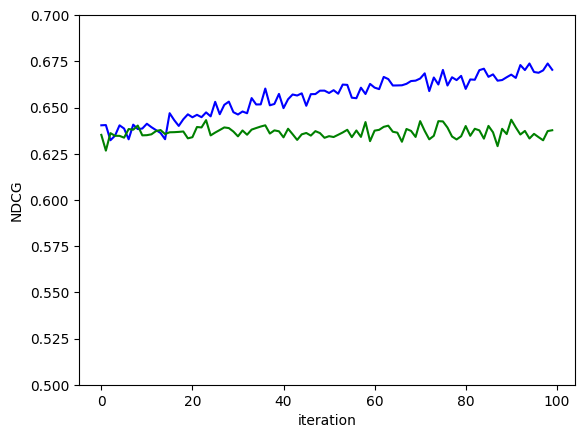

In [ ]:
ucb_metrics_pdf = pd.DataFrame(ucb_metrics)
rnd_metrics_pdf = pd.DataFrame(rnd_metrics)

plt.plot(ucb_metrics_pdf['NDCG@5'], color='b')
plt.plot(rnd_metrics_pdf['NDCG@5'], color='g')
plt.xlabel('iteration')
plt.ylabel('NDCG')
plt.ylim(0.5, 0.7)
plt.savefig('ndcg_als_lr.png', dpi=300)

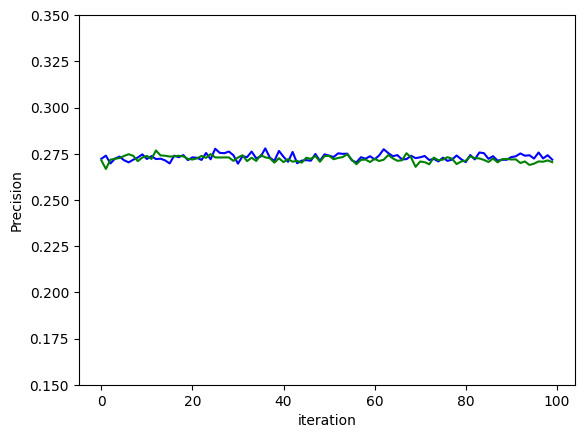

In [ ]:
plt.plot(ucb_metrics_pdf['Precision@5'], color='b')
plt.plot(rnd_metrics_pdf['Precision@5'], color='g')
plt.xlabel('iteration')
plt.ylabel('Precision')
plt.ylim(0.15, 0.35)
plt.savefig('precision_als_lr.png', dpi=300)

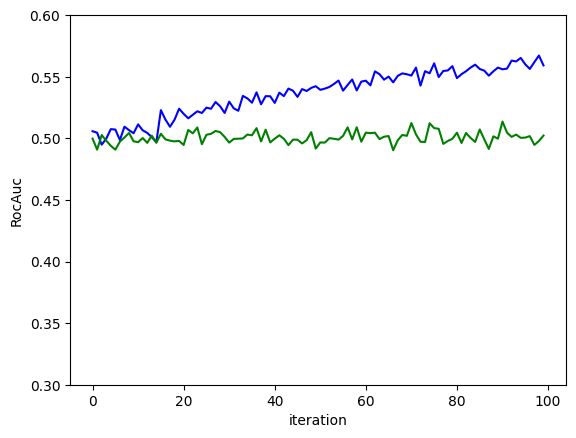

In [ ]:
plt.plot(ucb_metrics_pdf['RocAuc@5'], color='b')
plt.plot(rnd_metrics_pdf['RocAuc@5'], color='g')
plt.xlabel('iteration')
plt.ylabel('RocAuc')
plt.ylim(0.3, 0.6)
plt.savefig('rocauc_als_lr.png', dpi=300)

In [ ]:
ucb_metrics_pdf.to_csv('metrics_ucb_lr_als.csv', index=False)
rnd_metrics_pdf.to_csv('metrics_baseline_als.csv', index=False)